In [ ]:
import pandas as pd
import random
import einops
import time

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from nnsight import CONFIG
from nnsight import LanguageModel

import os
import numpy as np
import torch
import json
from tqdm import tqdm
import matplotlib.pyplot as plt


YOUR_API_KEY = ""
CONFIG.set_default_api_key(YOUR_API_KEY)

HF_TOKEN = ''
os.environ['HF_TOKEN'] = HF_TOKEN
clear_output()

llamaInstruct = LanguageModel("meta-llama/Llama-3.3-70B-Instruct", device_map="auto")
llamaInstruct.model.eval()
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

torch.cuda.empty_cache()

head_dim = llamaInstruct.model.config.head_dim # 128
num_heads = llamaInstruct.model.config.num_attention_heads # 64
num_key_value_heads = llamaInstruct.model.config.num_key_value_heads # 8 


In [2]:
df = pd.read_csv("debiased_dataset.csv", parse_dates=["x"], dayfirst=True, infer_datetime_format=True)

dataframes = {}
metadata = {}
formatted_strings = {}
for table_id, table in df.groupby("table_id"):
    title = table["title"].iloc[0]
    x_col = table["x_label"].iloc[0]
    y_col = table["y_label"].iloc[0]

    df_xy = table[["x", "y"]].reset_index(drop=True)
    df_xy.columns = [x_col, y_col]
    dataframes[table_id] = df_xy

    row_max = df_xy.loc[df_xy[y_col].idxmax()]
    row_min = df_xy.loc[df_xy[y_col].idxmin()]

    metadata[table_id] = {'trend_line': table["trend_line"].iloc[0], 
                          'trend': table["trend"].iloc[0],
                          'x_type': table["x_type"].iloc[0],
                          'max': float(row_max[y_col]),
                          'max_pos': row_max[x_col], 
                          'max_row': df_xy[y_col].idxmax(),
                          'min': float(row_min[y_col]),
                          'min_pos': row_min[x_col],
                          'min_row': df_xy[y_col].idxmin()}

    values = []
    for _, row in table.iterrows():
        x_val = row["x"]
        # Format dates
        if pd.api.types.is_datetime64_any_dtype(type(x_val)):
            x_val = pd.to_datetime(x_val).strftime('%Y-%m-%d')
        y_val = row["y"]
        y_str = f"{int(y_val)}" if float(y_val).is_integer() else f"{y_val}"
        values.append(f"{x_val} {y_str}")   

    table_str = f"{title} <s> {x_col} {y_col} " + " ".join(values)
    formatted_strings[table_id] = table_str

formatted_strings
# with open('formatted_strings.json', 'w') as f:
#     json.dump(formatted_strings, f)

# with open('dataframes.json', 'w') as f:
#     json.dump(dataframes, f)

/var/folders/jq/l62fj9810d1999b7wv4qbz400000gn/T/ipykernel_1570/1398831320.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv("debiased_dataset.csv", parse_dates=["x"], dayfirst=True, infer_datetime_format=True)
/var/folders/jq/l62fj9810d1999b7wv4qbz400000gn/T/ipykernel_1570/1398831320.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("debiased_dataset.csv", parse_dates=["x"], dayfirst=True, infer_datetime_format=True)


{0: 'Data Summary <s> Time Value 786 168.4 1571.9 161.1 2357.9 153 3143.8 143.9 3929.8 133.3 4715.8 120.8 5501.7 105.4 6287.7 85.7 7073.6 57.9 7859.6 10.3',
 1: 'Trend Overview <s> Step Score Grp Z 2.83 Grp I 29.17 Grp R 44.58 Grp W 55.52 Grp T 64 Grp E 70.93 Grp J 76.8 Grp D 81.87 Grp C 86.35 Grp K 90.36',
 2: 'Analysis Results <s> Index Response 1991-06-11 78.7 1991-07-11 71.3 1991-08-10 64 1991-09-09 56.7 1991-10-09 49.4 1991-11-08 42.1 1991-12-08 34.8 1992-01-07 27.4 1992-02-06 20.1 1992-03-07 12.8',
 3: 'Experiment Log <s> Cycle Measurement 722.5 33.55 1445 32.34 2167.5 31.2 2890 30.12 3612.5 29.1 4335 28.14 5057.6 27.22 5780.1 26.36 6502.6 25.54 7225.1 24.76',
 4: 'Daily Report <s> Sample Observation Group K 29 Group W 31 Group C 33 Group G 35 Group S 38 Group H 42 Group U 45 Group E 50 Group R 55 Group O 61',
 5: 'Session Data <s> Date Total 339.42 121 678.85 116 1018.27 110 1357.69 103 1697.12 96 2036.54 86 2375.96 75 2715.38 61 3054.81 41 3394.23 6',
 6: 'Group Comparison <s> 

In [4]:
# Dictionary to store the new shuffled dataframes
shuffled_dataframes = {}
shuffled_strings = {}

for table_id, table in df.groupby("table_id"):
    title = table["title"].iloc[0]
    x_col = table["x_label"].iloc[0]
    y_col = table["y_label"].iloc[0]

    df_xy = table[["x", "y"]].reset_index(drop=True)
    # print (df_xy)
    df_xy.columns = [x_col, y_col]

    # Shuffle y values
    shuffled_y = df_xy[y_col].sample(frac=1, random_state=42).reset_index(drop=True)

    # Keep x values the same
    shuffled_df = pd.DataFrame({x_col: df_xy[x_col], y_col: shuffled_y})
    shuffled_dataframes[table_id] = shuffled_df

    # # Format as string
    values = []
    for i, row in shuffled_df.iterrows():
        x_val = row[x_col]
        # Format dates
        if pd.api.types.is_datetime64_any_dtype(df_xy[x_col].dtype):
            x_val = pd.to_datetime(x_val).strftime('%Y-%m-%d')
        y_val = row[y_col]
        y_str = f"{int(y_val)}" if float(y_val).is_integer() else f"{y_val}"
        values.append(f"{x_val} {y_str}")

    table_str = f"{title} <s> {x_col} {y_col} " + " ".join(values)
    shuffled_strings[table_id] = table_str

shuffled_strings

{0: 'Data Summary <s> Time Value 786 57.9 1571.9 161.1 2357.9 120.8 3143.8 168.4 3929.8 85.7 4715.8 153 5501.7 10.3 6287.7 133.3 7073.6 143.9 7859.6 105.4',
 1: 'Trend Overview <s> Step Score Grp Z 86.35 Grp I 29.17 Grp R 70.93 Grp W 2.83 Grp T 81.87 Grp E 44.58 Grp J 90.36 Grp D 64 Grp C 55.52 Grp K 76.8',
 2: 'Analysis Results <s> Index Response 1991-06-11 20.1 1991-07-11 71.3 1991-08-10 42.1 1991-09-09 78.7 1991-10-09 27.4 1991-11-08 64 1991-12-08 12.8 1992-01-07 49.4 1992-02-06 56.7 1992-03-07 34.8',
 3: 'Experiment Log <s> Cycle Measurement 722.5 25.54 1445 32.34 2167.5 28.14 2890 33.55 3612.5 26.36 4335 31.2 5057.6 24.76 5780.1 29.1 6502.6 30.12 7225.1 27.22',
 4: 'Daily Report <s> Sample Observation Group K 55 Group W 31 Group C 42 Group G 29 Group S 50 Group H 33 Group U 61 Group E 38 Group R 35 Group O 45',
 5: 'Session Data <s> Date Total 339.42 41 678.85 116 1018.27 86 1357.69 121 1697.12 61 2036.54 110 2375.96 6 2715.38 96 3054.81 103 3394.23 75',
 6: 'Group Comparison <s> 

In [2]:
# mixed_datatables = {}
# mixed_strings = {}

# for i in range(100):
#     if i < 50:
#         mixed_datatables[i] = dataframes[i].copy()
#         mixed_strings[i] = formatted_strings[i]
#     else:
#         mixed_datatables[i] = shuffled_dataframes[i].copy()
#         mixed_strings[i] = shuffled_strings[i]
# mixed_datatables

with open('mixed_datatables_updated.json', 'r') as f:
    loaded_datatables = json.load(f)

# Convert lists of row dicts back to DataFrames
mixed_datatables = {
    k: pd.DataFrame(v)
    for k, v in loaded_datatables.items()
}

# Load mixed_strings
with open('mixed_strings_updated.json', 'r') as f:
    mixed_strings = json.load(f)

In [3]:
def decimal_places(num):
    s = str(num)
    if '.' in s:
        return len(s.split('.')[1])
    else:
        return 0
def int_to_string(y_val):
    return f"{int(y_val)}" if float(y_val).is_integer() else f"{y_val}"

def find_subsequence(full, sub):
    for i in range(len(full) - len(sub) + 1):
        if full[i:i+len(sub)] == sub:
            return i, i + len(sub)
    return None, None

In [ ]:
# with open('corrupted_datatables_updated.json', 'r') as f:
#     corrupted_datatables = json.load(f)

# with open('corrupted_answers_updated.json', 'r') as f:
#     answers = json.load(f)
answers = []
corrupted_datatables = {}

for table_id, table in df.groupby("table_id"):
    table = table.reset_index(drop=True)

    title = table["title"].iloc[0]
    x_col = table["x_label"].iloc[0]
    y_col = table["y_label"].iloc[0]

    table_df = mixed_datatables[str(table_id)].copy()
    y_column = table_df.columns[1]
    max_index = table_df[table_df.columns[1]].idxmax()
    maximum = table_df[table_df.columns[1]].max()
    minimum = table_df[y_column].min()
    second_max = table_df[y_column].nlargest(2).iloc[-1]
    new_value = round(random.uniform(minimum, second_max), decimal_places(minimum))
    table_df.loc[max_index, y_column] = new_value

    y_str = f"{int(y_val)}" if float(y_val).is_integer() else f"{y_val}"

    answers.append((int_to_string(maximum), int_to_string(second_max)))

    values = []
    for i, row in table.iterrows():
        x_val = row["x"]
        # Format dates
        if pd.api.types.is_datetime64_any_dtype(type(x_val)):
            x_val = pd.to_datetime(x_val).strftime('%Y-%m-%d')
        y_val = table_df.loc[i, table_df.columns[1]]
        y_str = f"{int(y_val)}" if float(y_val).is_integer() else f"{y_val}"
        values.append(f"{x_val} {y_str}")   

    table_str = f"{title} <s> {x_col} {y_col} " + " ".join(values)
    corrupted_datatables[str(table_id)] = table_str

with open('corrupted_datatables_updated.json', 'w') as f:
    json.dump(corrupted_datatables, f)

with open('corrupted_answers_updated.json', 'w') as f:
    json.dump(answers, f)

In [4]:
def generate_max_chat(datatable):
    messages = [
        {
            "role": "system",
            "content": (
                "You are a data scientist. Given a data table, return only the *maximum y-value*. "
                "Respond with only the y-value as it appears in the table. Do not explain. "
                "Do not return the x-value or the row index."
            )
        },
        {
            "role": "user",
            "content": (
                "What is the maximum y-value?\n"
                "Data Table:\n" + datatable + "\n\n"
            )
        }
    ]
    return messages


In [7]:
# answers = answers[:2]
answer_token_indices = [
        [llamaInstruct.tokenizer(answers[i][j])["input_ids"][1:] for j in range(2)]
        for i in range(len(answers))
]
answer_token_indices

[[[8953, 13, 19], [10718, 13, 16]],
 [[1954, 13, 1927], [4218, 13, 1758]],
 [[2495, 13, 22], [6028, 13, 18]],
 [[1644, 13, 2131], [843, 13, 1958]],
 [[5547], [2131]],
 [[7994], [8027]],
 [[1135], [1774]],
 [[10410], [9423]],
 [[10680, 13, 2491], [10410, 13, 2148]],
 [[9748], [1484]],
 [[1484], [2421]],
 [[12815], [14087]],
 [[4044], [2495]],
 [[1682, 13, 19], [1627, 13, 18]],
 [[16955, 13, 22], [8273, 13, 2495]],
 [[2096, 13, 1419], [2137, 13, 5958]],
 [[14125, 13, 19], [14087, 13, 1774]],
 [[1484, 13, 23], [2721, 13, 23]],
 [[14274], [1049]],
 [[22418, 13, 2371], [17590, 13, 5925]],
 [[1682, 13, 16], [1544, 13, 17]],
 [[2550, 13, 20], [7529, 13, 1682]],
 [[6086], [5958]],
 [[3192], [10562]],
 [[9423], [6804]],
 [[4218], [2813]],
 [[5728, 13, 4103], [2287, 13, 2131]],
 [[11702], [7854]],
 [[12910], [18775]],
 [[8259], [6083]],
 [[1806, 13, 2075], [1758, 13, 806]],
 [[13679], [14261]],
 [[12171, 13, 2839], [2550, 13, 1627]],
 [[16567, 13, 16], [3192, 13, 806]],
 [[11771], [9992, 13, 20]

In [ ]:
def get_prompt(dt):
    prompt = generate_max_chat(dt)
    prompt_text = llamaInstruct.tokenizer.apply_chat_template(
        prompt, tokenize=False, add_generation_prompt=True
    )

    tokenized = llamaInstruct.tokenizer(
        prompt_text,
        return_offsets_mapping=True,
        return_tensors='pt'
    )
    flat_input_ids = tokenized['input_ids'][0].tolist()
    return prompt_text, flat_input_ids

prompts = []
for table_id in tqdm(mixed_strings):
    clean_dt = mixed_strings[str(table_id)]
    corrupted_dt = corrupted_datatables[str(table_id)]

    clean_prompt, clean_tokenized = get_prompt(clean_dt)
    corrupted_prompt, corrupted_tokenized = get_prompt(corrupted_dt)

    prompts.append(clean_prompt)
    prompts.append(corrupted_prompt)
    # break
len(prompts)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 100/100 [00:00<00:00, 1157.10it/s]


200

In [9]:
def to_serializable(x):
    try:
        if hasattr(x, "value"):  # Unwrap nnsight Proxy
            x = x.value
        if isinstance(x, list):
            return [to_serializable(v) for v in x]
        elif isinstance(x, dict):
            return {k: to_serializable(v) for k, v in x.items()}
        elif isinstance(x, torch.Tensor):
            if x.numel() == 1:
                return x.item()
            else:
                return x.detach().cpu().tolist()
        else:
            return float(x)  # fallback for numpy-like numbers
    except Exception as e:
        raise TypeError(f"Cannot serialize object {x} of type {type(x)}: {e}")

    
def unwrap_final_residuals(final_residuals):
    new_final_residuals = {}

    for layer, tensors in final_residuals.items():
        clean_list = []
        for t in tensors:
            clean = t
            if not isinstance(t, torch.Tensor):
                clean = t.value
            clean_list.append(clean)
        new_final_residuals[layer] = clean_list

    return new_final_residuals


In [ ]:
N_LAYERS = len(llamaInstruct.model.layers)
batch = 1
N_HEADS = 64 # attention heads
D_MODEL = int(8192) # size of model hidden
D_HEADS = int(D_MODEL/N_HEADS) #128 size of attention head
MAX_RETRIES = 5
RETRY_WAIT_SECONDS = 2


for prompt_id in range(0, len(prompts), 2):
    corrupt_id = (prompt_id + 1)
    file_id = prompt_id // 2

    print ('FILE ' + str(file_id))

    clean_answer_tokens = answer_token_indices[file_id][0]
    corrupt_answer_tokens = answer_token_indices[file_id][1]

    ioi_patching_results = {}
    patched_outputs = {}
    patched_probabilities = {}

    logits_path = os.path.join('path_patching/noising_mixed/logits/', f'{file_id}.json')
    outputs_path = os.path.join('path_patching/noising_mixed/outputs/', f'{file_id}.json')
    probs_path = os.path.join('path_patching/noising_mixed/probs/', f'{file_id}.json')
    if os.path.exists(logits_path):
        with open(logits_path, "r") as f:
            ioi_patching_results = json.load(f)
        with open(outputs_path, "r") as f:
            patched_outputs = json.load(f)
        with open(probs_path, "r") as f:
            patched_probabilities = json.load(f)

    for layer_idx in tqdm(reversed(range(len(llamaInstruct.model.layers)))):
        if str(layer_idx) in ioi_patching_results:
            continue
        for attempt in range(MAX_RETRIES):
            try:
                print ('Layer ' + str(layer_idx))
                with llamaInstruct.trace(remote = True) as tracer:
                    with tracer.invoke(prompts[corrupt_id]) as invoker:
                        # Get corrupted attention output for later patching
                        z_corrupt = {}
                        for l2 in range(N_LAYERS):
                            z = llamaInstruct.model.layers[l2].self_attn.o_proj.input # dimensions [1x15x4096] [batch x seq x D_MODEL]
                            z_reshaped = einops.rearrange(z, 'b s (nh dh) -> b s nh dh',nh=N_HEADS)
                            for h2 in range(N_HEADS):
                                z_corrupt[l2,h2] = z_reshaped[:,:,h2,:]
            
                    _ioi_patching_results = []
                    _patched_outputs = []
                    _probabilities = []
                    for head_idx in range(N_HEADS):
                        with tracer.invoke(prompts[prompt_id]) as invoker:
                            z_now = llamaInstruct.model.layers[layer_idx].self_attn.o_proj.input
                            z_now = einops.rearrange(z_now, 'b s (nh dh) -> b s nh dh',nh=N_HEADS)
                            z_now[:,-1,head_idx,:] = z_corrupt[layer_idx,head_idx][:, -1, :]

                            z_now = einops.rearrange(z_now, 'b s nh dh -> b s (nh dh)', nh=N_HEADS)
                            llamaInstruct.model.layers[layer_idx].self_attn.o_proj.input = z_now
                            
                            patched_logits = llamaInstruct.lm_head.output
                            patched_logit_diff = (
                                patched_logits[0, -1, clean_answer_tokens].mean() 
                                - patched_logits[0, -1, corrupt_answer_tokens].mean()
                            ).save()
                            patched_output = patched_logits.argmax(dim=-1).save()
                            
                            probs = torch.nn.functional.softmax(patched_logits[0], dim=-1)
                            _probabilities.append(probs[-len(clean_answer_tokens):, clean_answer_tokens].save())
                            _patched_outputs.append(patched_output)
                            _ioi_patching_results.append(patched_logit_diff)

                    ioi_patching_results[layer_idx] = _ioi_patching_results
                    patched_outputs[layer_idx] = _patched_outputs
                    patched_probabilities[layer_idx] = _probabilities

                serializable_results = {
                    int(layer): [to_serializable(score) for score in scores]
                    for layer, scores in ioi_patching_results.items()
                }
                with open(logits_path, "w") as f:
                    json.dump(serializable_results, f)

                serializable_probs = {
                    int(layer): [to_serializable(score) for score in scores]
                    for layer, scores in patched_probabilities.items()
                }
                with open(probs_path, "w") as f:
                    json.dump(serializable_probs, f)

                serializable_outputs = {
                    int(layer): [to_serializable(score) for score in scores]
                    for layer, scores in patched_outputs.items()
                }
                with open(outputs_path, "w") as f:
                    json.dump(serializable_outputs, f)

                break
            except Exception as e:
                print(f"ConnectionError on attempt {attempt + 1}/{MAX_RETRIES}: {e}")
                if attempt < MAX_RETRIES - 1:
                    time.sleep(RETRY_WAIT_SECONDS * (2 ** attempt))  # Exponential backoff
                else:
                    raise

FILE 91


0it [00:00, ?it/s]

Layer 6


2025-08-03 18:20:21,821 068d4ef1-ea6a-409e-ab0d-b9f177fcf610 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:20:22,003 068d4ef1-ea6a-409e-ab0d-b9f177fcf610 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:20:23,844 068d4ef1-ea6a-409e-ab0d-b9f177fcf610 - RUNNING: Your job has started running.
2025-08-03 18:20:41,379 068d4ef1-ea6a-409e-ab0d-b9f177fcf610 - COMPLETED: Your job has been completed.
74it [00:26,  2.78it/s]

Layer 5


2025-08-03 18:20:48,342 eb03e1b8-8394-49b8-b6ba-77336c073bc8 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:20:48,498 eb03e1b8-8394-49b8-b6ba-77336c073bc8 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:20:50,383 eb03e1b8-8394-49b8-b6ba-77336c073bc8 - RUNNING: Your job has started running.
2025-08-03 18:21:07,900 eb03e1b8-8394-49b8-b6ba-77336c073bc8 - COMPLETED: Your job has been completed.
75it [00:52,  1.19it/s]

Layer 4


2025-08-03 18:21:17,264 03e05fc4-114f-4874-9b58-b03c777df1c0 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:21:17,490 03e05fc4-114f-4874-9b58-b03c777df1c0 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:21:19,344 03e05fc4-114f-4874-9b58-b03c777df1c0 - RUNNING: Your job has started running.
2025-08-03 18:21:36,777 03e05fc4-114f-4874-9b58-b03c777df1c0 - COMPLETED: Your job has been completed.
76it [01:21,  1.58s/it]

Layer 3


2025-08-03 18:21:43,061 798624b8-b7e2-4a4b-a7e0-d26533a4c2d9 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:21:43,229 798624b8-b7e2-4a4b-a7e0-d26533a4c2d9 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:21:45,089 798624b8-b7e2-4a4b-a7e0-d26533a4c2d9 - RUNNING: Your job has started running.
2025-08-03 18:22:02,582 798624b8-b7e2-4a4b-a7e0-d26533a4c2d9 - COMPLETED: Your job has been completed.
77it [01:47,  2.47s/it]

Layer 2


2025-08-03 18:22:09,701 c7e8515e-6bed-4c0b-83b2-63a41e72f7c6 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:22:09,874 c7e8515e-6bed-4c0b-83b2-63a41e72f7c6 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:22:11,713 c7e8515e-6bed-4c0b-83b2-63a41e72f7c6 - RUNNING: Your job has started running.
2025-08-03 18:22:29,157 c7e8515e-6bed-4c0b-83b2-63a41e72f7c6 - COMPLETED: Your job has been completed.
78it [02:13,  3.65s/it]

Layer 1


2025-08-03 18:22:35,645 13798723-0497-426c-b431-9d7a10bbe3fc - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:22:35,812 13798723-0497-426c-b431-9d7a10bbe3fc - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:22:37,711 13798723-0497-426c-b431-9d7a10bbe3fc - RUNNING: Your job has started running.
2025-08-03 18:22:55,075 13798723-0497-426c-b431-9d7a10bbe3fc - COMPLETED: Your job has been completed.
79it [02:39,  5.11s/it]

Layer 0


2025-08-03 18:23:01,827 6b7bf49a-805e-43a5-a2ff-20631de878a5 - RECEIVED: Your job has been received and is waiting approval.
2025-08-03 18:23:01,975 6b7bf49a-805e-43a5-a2ff-20631de878a5 - APPROVED: Your job was approved and is waiting to be run.
2025-08-03 18:23:03,819 6b7bf49a-805e-43a5-a2ff-20631de878a5 - RUNNING: Your job has started running.
2025-08-03 18:23:21,194 6b7bf49a-805e-43a5-a2ff-20631de878a5 - COMPLETED: Your job has been completed.
80it [03:05,  2.32s/it]


In [47]:
acc_per_head = {layer_idx: [0 for _ in range(N_HEADS)] for layer_idx in range(N_LAYERS)}

for file_id in file_list:
    print ('FILE ' + str(file_id))
    clean_run_path = os.path.join('path_patching/clean_run/', f'{file_id}.pt')
    corrupted_run_path = os.path.join('path_patching/corrupted_run/', f'{file_id}.pt')

    # logits_path = os.path.join('path_patching/noising/logits/', f'{file_id}.json')
    outputs_path = os.path.join('path_patching/noising_mixed/outputs/', f'{file_id}.json')
    clean_run = torch.load(clean_run_path)
    corrupted_run = torch.load(corrupted_run_path)

    with open(outputs_path, "r") as f:
        patched_outputs = json.load(f)
        
    clean_text = llamaInstruct.tokenizer.batch_decode(clean_run['outputs'][0])[0]
    clean_result = clean_text[clean_text.rindex('<|end_header_id|>') + len('<|end_header_id|>'):].strip()
    # print (clean_result)
    corrupted_text = llamaInstruct.tokenizer.batch_decode(corrupted_run['outputs'][0])[0]
    corrupted_result = corrupted_text[corrupted_text.rindex('<|end_header_id|>') + len('<|end_header_id|>'):].strip()

    for layer_idx in range(N_LAYERS):
        variation_per_layer = []
        for head_idx in range(N_HEADS):
            token_ids = [int(x) for x in patched_outputs[str(layer_idx)][head_idx][0]]
            tokens = llamaInstruct.tokenizer.batch_decode(token_ids)
            last_index = len(tokens) - 1 - tokens[::-1].index('<|end_header_id|>') + 2
            result = ''.join(tokens[last_index:])

            if result == clean_result:
                acc_per_head[layer_idx][head_idx] += 1 


FILE 0
FILE 1
FILE 2
FILE 3
FILE 4
FILE 5
FILE 6
FILE 7
FILE 8
FILE 9
FILE 10
FILE 11
FILE 12
FILE 13
FILE 14
FILE 15
FILE 16
FILE 17
FILE 18
FILE 19
FILE 50
FILE 51
FILE 52
FILE 53
FILE 54
FILE 55
FILE 56
FILE 57
FILE 58
FILE 59
FILE 60
FILE 61


In [ ]:
count_per_head = {layer_idx: [0 for _ in range(N_HEADS)] for layer_idx in range(N_LAYERS)}
diff_per_head = {layer_idx: [0 for _ in range(N_HEADS)] for layer_idx in range(N_LAYERS)}
diff_per_table = {}
variation_per_table = {}
acc_per_head = {layer_idx: [0 for _ in range(N_HEADS)] for layer_idx in range(N_LAYERS)}


for file_id in range(0, len(prompts)//2, 1):
    logits_path = os.path.join('path_patching/noising_mixed/logits/', f'{file_id}.json')
    if not os.path.exists(logits_path):
        continue

    clean_run_path = os.path.join('path_patching/clean_run/', f'{file_id}.pt')
    corrupted_run_path = os.path.join('path_patching/corrupted_run/', f'{file_id}.pt')

    logits_path = os.path.join('path_patching/noising_mixed/logits/', f'{file_id}.json')
    outputs_path = os.path.join('path_patching/noising_mixed/outputs/', f'{file_id}.json')
    clean_run = torch.load(clean_run_path)
    corrupted_run = torch.load(corrupted_run_path)

    with open(logits_path, "r") as f:
        ioi_patching_results = json.load(f)
    with open(outputs_path, "r") as f:
        patched_outputs = json.load(f)

    variation_per_table[file_id] = []
    diff_per_table[file_id] = []

    print ('FILE ' + str(file_id))
        
    # print (clean_run)
    clean_logit = clean_run['logits'][0].item()
    # print (clean_run['logits'])
    clean_text = llamaInstruct.tokenizer.batch_decode(clean_run['outputs'][0])[0]
    clean_result = clean_text[clean_text.rindex('<|end_header_id|>') + len('<|end_header_id|>'):].strip()

    corrupted_text = llamaInstruct.tokenizer.batch_decode(corrupted_run['outputs'][0])[0]
    corrupted_result = corrupted_text[corrupted_text.rindex('<|end_header_id|>') + len('<|end_header_id|>'):].strip()

    print ('Correct: '  + str(answers[file_id][0]))
    print ('Clean: ' + str(clean_result)) 
    print ('Corrupted: ' + str(corrupted_result))
    print ('Logit: ' + str(clean_logit))

    all_values = [v for values in ioi_patching_results.values() for v in values]
    # mean = np.mean(all_values)
    # std = np.std(all_values) * 1

    for layer_idx in range(N_LAYERS):
        variation_per_layer = []
        diff_per_layer = []
        for head_idx in range(N_HEADS):
            logit_diff = ioi_patching_results[str(layer_idx)][head_idx]
            # print(logit_diff)

            # print (logit_diff)
            token_ids = [int(x) for x in patched_outputs[str(layer_idx)][head_idx][0]]
            tokens = llamaInstruct.tokenizer.batch_decode(token_ids)
            last_index = len(tokens) - 1 - tokens[::-1].index('<|end_header_id|>') + 2
            result = ''.join(tokens[last_index:])

            if result == clean_result:
                acc_per_head[layer_idx][head_idx] += 1 

            variation = (logit_diff - clean_logit) / clean_logit
            variation_per_layer.append(variation)
            diff_per_layer.append(clean_logit - logit_diff)

            # is_correct = 'X'
            # print(count_per_head[layer_idx][head_idx])
            # if count_per_head[layer_idx][head_idx] > 10:
            #     print ('Layer ' + str(layer_idx) + " Head " + str(head_idx) + ": " +  str(logit_diff))

            if abs(variation) > 0.10:
                count_per_head[layer_idx][head_idx] += 1
                diff_per_head[layer_idx][head_idx] += variation

                # print ('Layer ' + str(layer_idx) + " Head " + str(head_idx) + ": " +  str(variation))
            # break
        variation_per_table[file_id].append(variation_per_layer)
        diff_per_table[file_id].append(diff_per_layer)

FILE 0
Correct: 168.4
Clean: 168
Corrupted: 161
Logit: 1.1875
FILE 1
Correct: 90.36
Clean: 90
Corrupted: 86
Logit: 9.25
FILE 2
Correct: 78.7
Clean: 78
Corrupted: 71
Logit: 7.3125
FILE 3
Correct: 33.55
Clean: 33
Corrupted: 32
Logit: 5.0625
FILE 4
Correct: 61
Clean: 61
Corrupted: 55
Logit: 17.0
FILE 5
Correct: 121
Clean: 339
Corrupted: 116
Logit: 11.0
FILE 6
Correct: 50
Clean: 50
Corrupted: 45
Logit: 16.875
FILE 7
Correct: 148
Clean: 148
Corrupted: 133
Logit: 17.875
FILE 8
Correct: 165.49
Clean: 165
Corrupted: 148
Logit: 7.5625
FILE 9
Correct: 129
Clean: 129
Corrupted: 99
Logit: 7.125
FILE 10
Correct: 99
Clean: 99
Corrupted: 88
Logit: 13.625
FILE 11
Correct: 264
Clean: 606
Corrupted: 606
Logit: 9.375
FILE 12
Correct: 87
Clean: 87
Corrupted: 78
Logit: 18.25
FILE 13
Correct: 29.4
Clean: 29
Corrupted: 26
Logit: 6.0
FILE 14
Correct: 269.7
Clean: 269
Corrupted: 240
Logit: 11.875
FILE 15
Correct: 44.23
Clean: 44
Corrupted: 39
Logit: 8.625
FILE 16
Correct: 247.4
Clean: 247
Corrupted: 236
Logit:

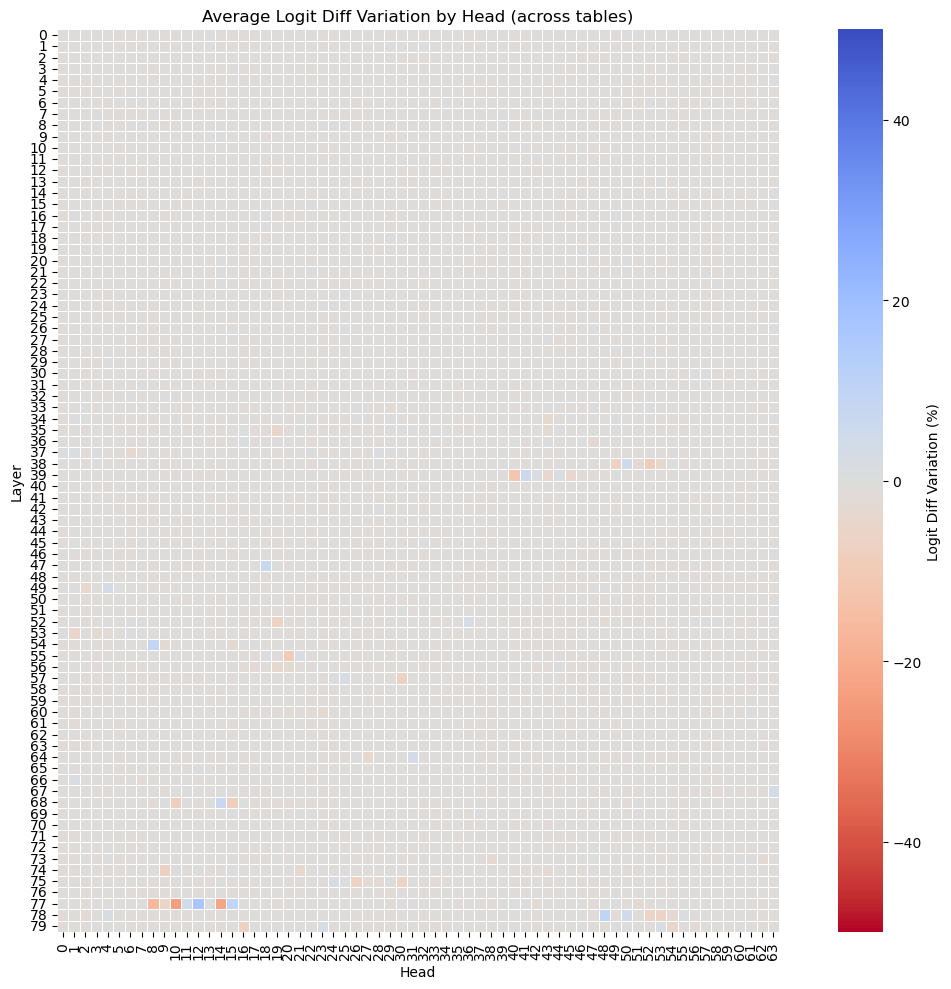

In [26]:
variation_tensor = torch.stack([
    torch.tensor(variation_per_table[table_id])
    for table_id in variation_per_table
])  # shape: [num_tables, 80, 64]

# # Take mean over the first dimension (tables)
mean_variation = variation_tensor.mean(dim=0)  # shape: [80, 64]

if isinstance(mean_variation, torch.Tensor):
    mean_variation = mean_variation.numpy()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    mean_variation * 100,      # scale to percent
    cmap="coolwarm_r",             # red = negative, blue = positive
    center=0,                  # zero-centered
    vmin=-50, vmax=50,       # clip extremes for visibility
    xticklabels=range(64),     # head indices
    yticklabels=range(80),     # layer indices
    square=True,
    cbar_kws={"label": "Logit Diff Variation (%)"},
    linewidths=0.5,
    linecolor='white'
)

plt.xlabel("Head")
plt.ylabel("Layer")
plt.title("Average Logit Diff Variation by Head (across tables)")
plt.tight_layout()
plt.show()

In [66]:
threshold = 5  # percent

for layer_idx in range(mean_variation.shape[0]):
    for head_idx in range(mean_variation.shape[1]):
        value = mean_variation[layer_idx, head_idx] * 100
        if value < -3 and layer_idx < 40:
            print(f"Layer {layer_idx} Head {head_idx}: {value:.2f}%")


Layer 34 Head 43: -4.12%
Layer 35 Head 19: -4.67%
Layer 37 Head 6: -3.73%
Layer 38 Head 49: -7.20%
Layer 38 Head 51: -3.12%
Layer 38 Head 52: -8.79%
Layer 38 Head 53: -3.88%
Layer 39 Head 40: -12.05%
Layer 39 Head 43: -4.11%
Layer 39 Head 45: -4.22%
